In [1]:
import torch
import torch.nn as nn
import numpy as np

import os
import imageio
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from dataset import get_rays
from rendering import rendering
from model import Nerf
from ml_helpers import *

In [2]:
# Test if intersect exists
model = Nerf(hidden_dim=128)
print("Has intersect method:", hasattr(model, 'intersect'))

Has intersect method: True


In [3]:
# Check MPS availability
def get_device():
    if torch.backends.mps.is_available():
        return 'mps'
    return 'cpu'

# Modified training setup
device = get_device()
print(f"Using device: {device}")

Using device: mps


# Camera / Dataset

In [4]:
batch_size = 1024

o, d, target_px_values = get_rays('fox', mode='train')
dataloader = DataLoader(torch.cat((torch.from_numpy(o).reshape(-1, 3).type(torch.float),
                                torch.from_numpy(d).reshape(-1, 3).type(torch.float),
                                torch.from_numpy(target_px_values).reshape(-1, 3).type(torch.float)), dim=1),
                    batch_size=batch_size, shuffle=True)

dataloader_warmup = DataLoader(torch.cat((torch.from_numpy(o).reshape(90, 400, 400, 3)[:, 100:300, 100:300, :].reshape(-1, 3).type(torch.float),
                               torch.from_numpy(d).reshape(90, 400, 400, 3)[:, 100:300, 100:300, :].reshape(-1, 3).type(torch.float),
                               torch.from_numpy(target_px_values).reshape(90, 400, 400, 3)[:, 100:300, 100:300, :].reshape(-1, 3).type(torch.float)), dim=1),
                       batch_size=batch_size, shuffle=True)


test_o, test_d, test_target_px_values = get_rays('fox', mode='test')

# Training

In [5]:
def training_with_warmup(model, optimizer, scheduler, tn, tf, nb_bins, device='mps'):
    """
    Complete training pipeline with warmup and full training phases
    """
    print("Starting warm-up phase...")
    # Warmup training
    warmup_loss = train_model(
        model=model,
        optimizer=optimizer,
        scheduler=scheduler,
        dataloader=dataloader_warmup,
        tn=tn,
        tf=tf,
        nb_bins=nb_bins,
        nb_epochs=1,
        device=device
    )
    plot_training_loss(warmup_loss)
    
    print("\nStarting main training phase...")
    # Main training
    main_loss = train_model(
        model=model,
        optimizer=optimizer,
        scheduler=scheduler,
        dataloader=dataloader,
        tn=tn,
        tf=tf,
        nb_bins=nb_bins,
        nb_epochs=nb_epochs,
        device=device
    )
    plot_training_loss(main_loss)
    
    return warmup_loss, main_loss

In [6]:
def train_model(model, optimizer, scheduler, dataloader, tn, tf, nb_bins, nb_epochs, device='mps'):
    training_loss = []
    
    for epoch in range(nb_epochs):
        epoch_loss = []
        for batch in tqdm(dataloader, desc=f'Epoch {epoch+1}/{nb_epochs}'):
            # Move batch to device
            o = batch[:, :3].to(device)
            d = batch[:, 3:6].to(device)
            target = batch[:, 6:].to(device)
            
            prediction = rendering(model, o, d, tn, tf, nb_bins=nb_bins, device=device)
            loss = ((prediction - target)**2).mean()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss.append(loss.item())
        
        avg_loss = sum(epoch_loss) / len(epoch_loss)
        training_loss.append(avg_loss)
        print(f"Epoch {epoch+1}/{nb_epochs}, Loss: {avg_loss:.4f}")
        
        scheduler.step()
        
        # Save model checkpoints to CPU
        torch.save(model.cpu().state_dict(), f'model_nerf_epoch_{epoch+1}.pt')
        model.to(device)
    
    return training_loss

In [7]:
def training(model, optimizer, scheduler, tn, tf, nb_bins, nb_epochs, data_loader, device='mps'):
    print("Warning: This is the legacy training function. Consider using train_model instead.")
    
    training_loss = []
    for epoch in (range(nb_epochs)):
        for batch in tqdm(data_loader):
            o = batch[:, :3].to(device)
            d = batch[:, 3:6].to(device)
            
            target = batch[:, 6:].to(device)
            
            prediction = rendering(model, o, d, tn, tf, nb_bins=nb_bins, device=device)
            
            loss = ((prediction - target)**2).mean()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            training_loss.append(loss.item())
            
        scheduler.step()
        
        torch.save(model.cpu().state_dict(), f'model_nerf_epoch_{epoch+1}.pt')
        model.to(device)
        
    return training_loss

In [8]:
# Restart the kernel in your notebook
import torch
from model import Nerf  # Re-import the updated model

Starting warm-up phase...


Epoch 1/1: 100%|████████████████████████████████████████████| 3516/3516 [04:38<00:00, 12.60it/s]

Epoch 1/1, Loss: 0.1171


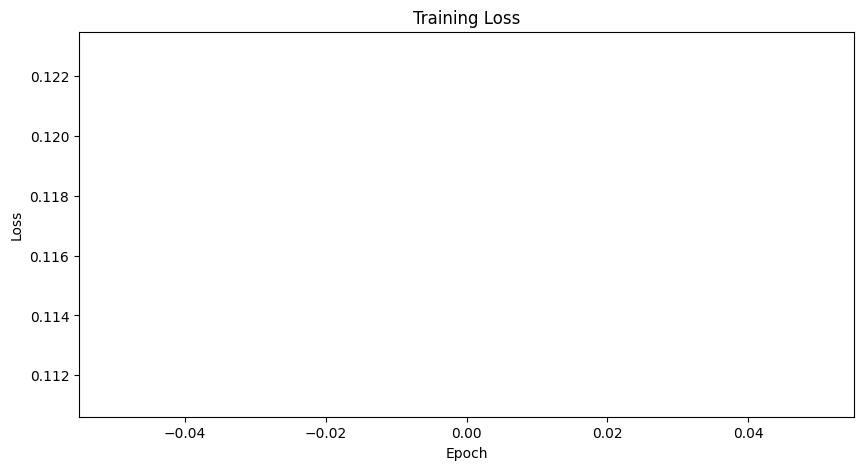


Starting main training phase...


Epoch 1/1: 100%|██████████████████████████████████████████| 14063/14063 [18:52<00:00, 12.42it/s]

Epoch 1/1, Loss: 0.0016


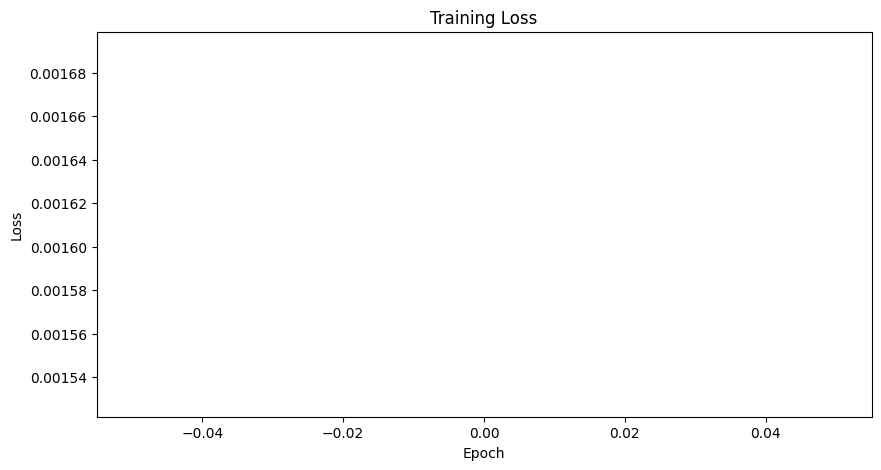

TypeError: plot_training_loss() got an unexpected keyword argument 'phase'

In [10]:
tn = 8.
tf = 12.
nb_epochs = 1
lr = 1e-3
gamma = .5
nb_bins = 100

# Initialize model and move to MPS
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
model = Nerf(hidden_dim=128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 10], gamma=gamma)

# Train the model
warmup_loss, main_loss = training_with_warmup(
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    tn=tn,
    tf=tf,
    nb_bins=nb_bins,
    device=device
)

# Plot the training loss
plot_training_loss((warmup_loss, main_loss), phase='full')


'''
training_loss = training(model, optimizer, scheduler, tn, tf, nb_bins, 1, dataloader_warmup, device=device)
plt.plot(training_loss)
plt.show()
training_loss = training(model, optimizer, scheduler, tn, tf, nb_bins, nb_epochs, dataloader, device=device)
plt.plot(training_loss)
plt.show()
'''

In [ ]:
torch.save(model, 'model_nerf')